In [1]:
# Test script for classification
# Import packages

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import numpy as np
import pandas as pd
import os
import sys
import importlib


# Good idea to add this folder to the json.settings file as "python.analysis.extraPaths".
sys.path.append('../functionScripts/')

import plotFunctions # totalCountsPlot, data_heatmap, correlation_plot
import analysisFunctions
import initFunctions as initf #import createDirs, debugReport, loadLightSheetData
import classifyFunctions
import helperFunctions

importlib.reload(initf)

# Set Paths to data and output
dirDict = dict()
rootDir = 'C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\'
dirDict['atlasDir'] = rootDir + 'Atlas\\'
dirDict['dataDir'] = rootDir + 'Data\\'
dirDict['B1'] =       dirDict['dataDir'] + 'lightSheetV1\\'
dirDict['B2'] =       dirDict['dataDir'] + 'lightSheetV2Rev\\'   #3/6/23 - Looking at the new, Realigned batch 2 data. #Realigned
dirDict['B2_Orig'] =  dirDict['dataDir'] + 'lightSheetV2\\'
dirDict['B3'] =       dirDict['dataDir'] + 'lightSheetV3\\'      #3/6/23 - Batch 3 with MDMA
dirDict['outputFormat'] = 'svg'

batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).
testSplit = False           # Splits an individual drug for the sake of examining self-similarity
oldBatch2 = False

debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor per mouse.
debug_ROI = ['Dorsal nucleus raphe']
outputFormat = 'png'

switchDir = dict(testSplit=testSplit, batchSplit=batchSplit, splitTag=splitTag, oldBatch2=oldBatch2, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI, outputFormat=outputFormat)

# Make directories, and add their strings to the directory dictionary.
dirDict = initf.createDirs(rootDir, switchDir, dirDict)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


evaluating model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(l1_ratio=0.5, multi_class='multinomial',
                   penalty='elasticnet', solver='saga')
Performing CV split 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

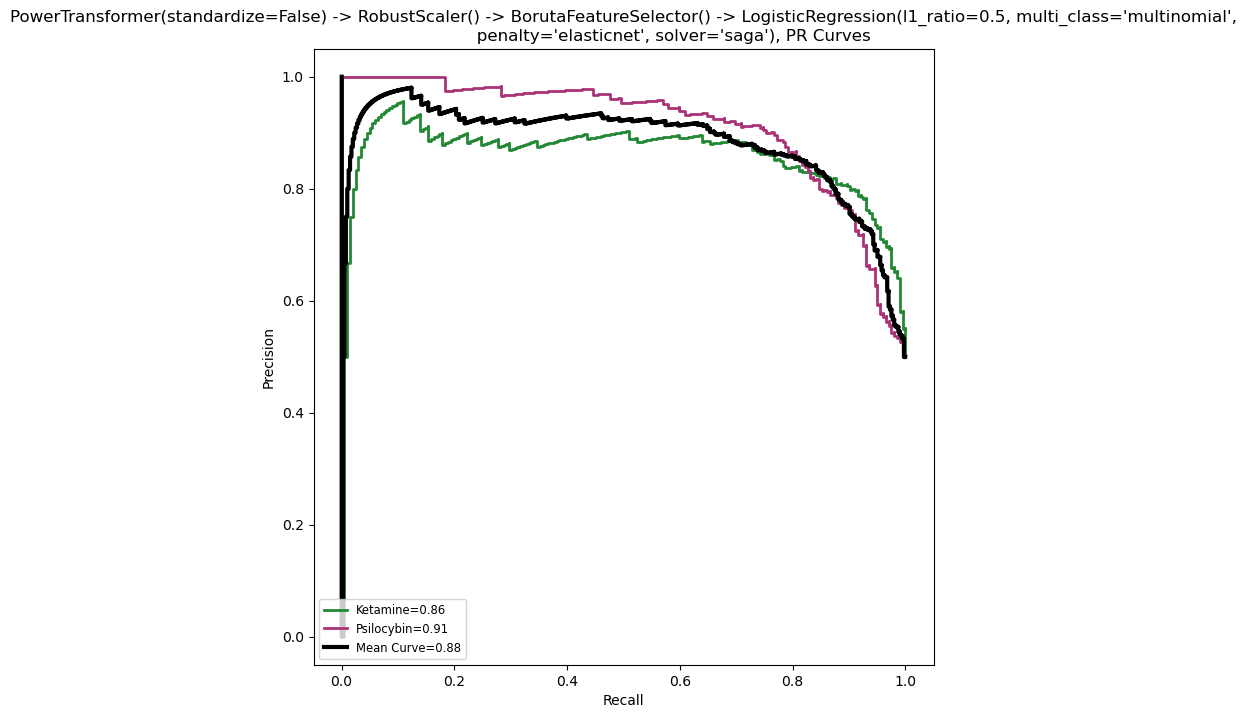

Real: 0.84 accuracy with a standard deviation of 0.22


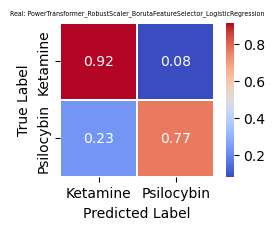

==== Ketamine vs Psilocybin ==== 
 Features per Model: [14, 13, 14, 13, 14, 14, 16, 11, 12, 11, 12, 12, 12, 12, 14, 13, 12, 14, 12, 14, 12, 13, 10, 12, 11, 17, 12, 14, 11, 10, 13, 10, 15, 13, 13, 12, 11, 12, 9, 12, 11, 13, 12, 12, 12, 13, 12, 17, 17, 12, 14, 13, 12, 14, 12, 9, 9, 13, 10, 16, 15, 14, 11, 9, 10, 9, 13, 13, 13, 14, 13, 15, 10, 14, 10, 14, 11, 11, 15, 12, 13, 15, 13, 13, 12, 10, 11, 13, 12, 11, 13, 15, 16, 16, 13, 14, 14, 12, 15, 12, 14]
Parameters: 
 
Total Regions = 92 
 Present 1x: 18 - AIp, CA1, PD, FC, LSr, CM, DCO, SFO, PAR, VISp, LA, VISpl, SSp-n, VISli, RR, GPe, LAV, RL
Present 2x: 12 - IPN, I5, NTB, AUDv, MDRN, VeCB, MD, GPi, PCG, PPY, AUDpo, CL
Present 3x: 6 - PeF, IMD, NLOT, HATA, MOs, PL
Present 4x: 3 - RCH, SPA, RPO
Present 5x: 9 - OV, TRN, AON, PDTg, MDRNd, PA, SNc, Acs5, SCH
Present 6x: 3 - AP, PR, ENTm
Present 7x: 3 - LM, SSp-m, PCN
Present 8x: 4 - VISa, CEA, ACVII, OT
Present 9x: 2 - ADP, FS
Present 10x: 1 - GRN
Present 11x: 2 - SUB, RSPagl
Present 12x: 2 

In [4]:
# Reload in case anything updated in these functions
importlib.reload(classifyFunctions)
importlib.reload(plotFunctions)
importlib.reload(helperFunctions)

# Set a random seed for reproducibility.
np.random.seed(seed = 31415)

classifyDict = dict()

# Parameters for pivoting the data
classifyDict['data'] = 'count_norm' #cell_density, count, count_norm, density_norm
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'class_PsiKet' # 'drug', 'class_5HT2A', 'class_5HTR', 'class_PsiKet', 'class_PsiSSRI', 'class_5HTR', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI', 'class_PsiDF'
# Defined in hf.create_drugClass_dict()
# classifyVec = ['class_PsiDMT', 'class_5HTR', 'class_PsiDF']

# Parameters for feature scaling and aggregation
classifyDict['featurefilt'] = False # True, False
classifyDict['filtType'] = 'min' # Min removes the bottom 1%, Max removes the top 99th percentile.
classifyDict['featureAgg'] = False
classifyDict['featureSel_linkage'] = 'average'  # 'average', 'complete', 'single', 'ward' (if euclidean)
classifyDict['featureSel_distance'] = 'correlation' # 'correlation, 'cosine', 'euclidean'
classifyDict['cluster_count'] = 100 # Number of clusters to generate. Not used at the moment.
classifyDict['cluster_thres'] = 0.2 # Anything closer than this is merged into a cluster
 
# Parameters for Preprocessing and feature selection
classifyDict['model_featureTransform'] = True # True, False
classifyDict['model_featureScale'] = True # True, False
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_alpha'] = 0.05 # Used for Fdr, Fwe, and Fwe_BH

# If Fdr/Fwe/None are not used for feature selection, the number of k feature must be preset
classifyDict['model_featureSel_mode'] = 'gridCV' # 'gridCV', 'modelPer'
# classifyDict['model_featureSel_k'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
classifyDict['model_featureSel_k'] = [30]

# Parameters for classification
classifyDict['model'] = 'LogRegL2' #'LogRegL2', 'LogRegL1', 'LogRegElastic', 'LDA', 'RandomForest'
classifyDict['multiclass'] = 'multinomial' # 'ovr', 'multinomial'
classifyDict['max_iter'] = 100
classifyDict['CVstrat'] = 'ShuffleSplit' #'StratKFold', 'ShuffleSplit'

# ParamGrid Features - in instances where gridCV is set to true, these are the parameters that will be tested.
paramGrid = dict()
paramGrid['classif__l1_ratio'] = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]          # used for ElasticNet
# paramGrid['classif__C'] = [0.001, 0.01, 0.1, 1, 10]                    # used for LogisticRegression
paramGrid['classif__C'] = [1]                    # used for LogisticRegression
classifyDict['pGrid'] = paramGrid

classifyDict['shuffle'] = False
classifyDict['gridCV'] = False

if classifyDict['CVstrat'] == 'ShuffleSplit':
    classifyDict['CV_count'] = 100 # Number of folds for cross-validation
else:
    # K fold stratified can only afford n_classes of folds
    classifyDict['CV_count'] = 8 

# if classifyDict['label'] == 'drug':
#     classifyDict['test_size'] = 1/8
#     classifyDict['innerFold'] = 7
# else:
classifyDict['test_size'] = 1/4
classifyDict['innerFold'] = 4

classifyDict['saveLoadswitch'] = True
dirDict['uniqID'] = 'minThres'

# Load Pickle
lightsheet_data = pd.read_pickle('lightsheet_data.pkl') # lightsheet_data.pkl or lightsheet_all.pkl

# Big Data - the dataset prior to filtering based on summary structures
# lightsheet_data = pd.read_pickle('lightsheet_data_big.pkl')
# lightsheet_data.rename(columns={'Brain Area': 'Brain_Area'}, inplace=True)

# Resort drugs.
customOrder = ['PSI', 'KET', '5MEO', '6-F-DET', 'MDMA', 'A-SSRI', 'C-SSRI', 'SAL']
# Convert 'col1' to a Categorical data type with custom sort order
lightsheet_data['drug'] = pd.Categorical(lightsheet_data['drug'], categories=customOrder, ordered=True)

# Pure visualizations
# plotFunctions.meanCountPerRegion(lightsheet_data)
# lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)
# plotFunctions.histPrePostScale(lightsheet_data, ['count', 'count_norm'], dirDict)
# plotFunctions.data_heatmap(lightsheet_data, 'abbreviation', 'count', dirDict)
# plotFunctions.data_heatmap_single(lightsheet_data, 'abbreviation', 'count_norm', dirDict) # cell_density, count, count_norm, density_norm
# plotFunctions.data_heatmap_block(lightsheet_data, 'abbreviation', 'density_norm', dirDict) # cell_density, count, count_norm, density_norm

# DimRed
# plotFunctions.plotLowDimEmbed(lightsheet_data, 'count_norm', dirDict, 'LDA', classifyDict) # Second Arg either 'total_cells' or 'cell_density'

# plotFunctions.distance_matrix(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot_hier(lightsheet_data, classifyDict, dirDict)

# valRange = np.arange(1,9)
# grids = np.meshgrid(valRange, valRange, valRange, valRange, valRange, valRange, valRange, valRange)
# combinations = np.column_stack([grid.flatten() for grid in grids])
# classifyFunctions.bootstrap_fstat(lightsheet_data, classifyDict, dirDict)
# lightsheet_data['drug'] = lightsheet_data['drug'].replace('DMT', '5-MeO-DMT')

# classifyDict['data'] = 'count' #cell_density, count, count_norm, density_norm, count_norm_scaled
# classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)

# classifyDict['data'] = 'count_norm' #cell_density, count, count_norm, density_norm, count_norm_scaled
classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)

In [ ]:
# classifyVec = ['class_PsiKet', 'class_PsiSSRI', 'class_5HTR', 'class_DT', 'class_SSRI'] # 'drug', 'class_5HT2A', 'class_5HTR', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI'
classifyVec = ['class_PsiDMT', 'class_5HT2A', 'class_5HTR', 'class_Speed', 'class_PsiMDMA', 'class_SSRI', 'class_PsiDF', 'class_PsiSSRI', 'class_PsiKet' ]
# classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'

# Figure 4
# Psi vs DMT ('class_PsiDMT'), Psi/DMT vs 6FDET ('class_5HTR'), Psi vs 6FDET ('class_PSiDF')
# classifyVec = ['class_PsiDMT', 'class_5HTR', 'class_PsiDF']

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
    except Exception:
      print(f"\n Failed to classify {i}")

In [ ]:
# Figure 5
# Psi vs DMT ('class_PsiDMT'), Psi/DMT vs 6FDET ('class_5HTR'), Psi vs 6FDET ('class_PSiDF')
# SSRI A vs C ('class_SSRI'), MDMA vs Psi ('class_PsiMDMA'), A-SSRI vs Psi ('class_PsiSSRI')

classifyVec = ['class_SSRI', 'class_PsiMDMA', 'class_PsiSSRI', 'class_PsiKet']

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
    except Exception:
      print(f"\n Failed to classify {i}")